# Visualize

## 1. Imports

In [1]:
import os
import re
import gc
import torch
import warnings
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from utils.python_utils import dotdict, alpha_sort

warnings.filterwarnings("ignore")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
if sns.__version__ != '0.12.1': raise NotImplementedError

### Paths

In [2]:
version = '3.1'

history_dir = os.path.join('history','v'+version)
base_dir = os.path.join('docs','visuals','v'+version)

### Supporting Functions

In [3]:
subset=''
history={}
history_dict={}

# Make save directory
def make_save_dir(history):
    dataset = history['config']['main_dataset']

    strategy = history['strategy'] if history['config']['labeled_sampling']=='equal' else 'random_'+history['strategy']
    run = history['config']['run_name']
    config_str = '_'.join(history['file_name'].split('_')[0:5])
    
    plots_dir = os.path.join(base_dir,dataset,strategy,run,config_str)
    os.makedirs(plots_dir,exist_ok=True)

    return plots_dir

# Class labels
class_labels = {'dbpedia_14':{0:'Company', 1:'Edu Institution', 2:'Artist', 3:'Athlete', 4:'Office Holder',5:'Mean Of Trans', 6:'Building',\
                              7:'Natural Place', 8:'Village', 9:'Animal', 10:'Plant', 11:'Album', 12:'Film', 13:'Written Work'},
                'yahoo_answers':{0:"Society", 1:"Science", 2:"Health", 3:"Education", 4:"Computers",\
                                    5:"Sports", 6:"Business", 7:"Music", 8:"Family", 9:"Politics"}}

## 2. Load History Files

### Consolidate

In [7]:
history_dict = dict()

for dataset in os.listdir(history_dir):
    dataset_path = os.path.join(history_dir,dataset)
    if os.path.isdir(dataset_path):
        for run in os.listdir(dataset_path):
            run_path = os.path.join(dataset_path,run)
            if os.path.isdir(run_path):
                
                if dataset in history_dict: history_dict[dataset][run] = []
                else: history_dict[dataset] = {run:[]}
                
                for path, dirs, files in os.walk(run_path):
                    for file_ in files:
                        if file_[-10:] == 'history.pt' and dirs:
                            try:
                                history_dict[dataset][run].append(torch.load(os.path.join(run_path,file_)))
                                history_dict[dataset][run][-1]['file_name'] = file_
                            except:
                                print(dataset,run,file_)

### Save

In [8]:
save_path = os.path.join(history_dir,'consolidated_history.pt')
torch.save(history_dict,save_path)

### Load

In [4]:
save_path = os.path.join(history_dir,'consolidated_history.pt')
history_dict = dotdict(torch.load(save_path))
history_dict.datasets = list(history_dict.keys())
history_dict.runs = [list(history_dict[dataset].keys()) for dataset in history_dict.datasets]

### Info

In [33]:
print('Datasets  :',history_dict.datasets)
print('Runs:',history_dict.runs)
print('\nHistory keys:', history_dict[history_dict.datasets[0]][history_dict.runs[0][0]][0].keys())
print('\nConfig keys :', history_dict[history_dict.datasets[0]][history_dict.runs[0][0]][0]['config'].keys())

print('\nFile Counts:')
for dataset in history_dict.datasets:
    print('\nDataset:', dataset)
    for run, val in history_dict[dataset].items():
        print(len(val), run)

Datasets  : ['yahoo_answers']
Runs: [['Run1', 'Run2', 'Run3', 'Run4', 'Run5']]

History keys: dict_keys(['strategy', 'config', 'iteration', 'batch_size', 'epoch', 'train_loss', 'train_acc', 'val_loss', 'val_cw_f1', 'val_acc', 'val_cw_acc', 'test_loss', 'test_cw_f1', 'test_acc', 'test_cw_acc', 'labeled_set_size', 'unlabeled_set_size', 'selected_set_size', 'selected_in_domain', 'selected_out_domain', 'train_distribution', 'labeled_distribution', 'unlabeled_distribution', 'selected_distribution', 'predicted_distribution', 'pseudo_distribution', 'predicted_probs', 'predicted_prob_mean', 'predicted_prob_std', 'predicted_prob_max', 'predicted_prob_min', 'selected_probs', 'selected_prob_mean', 'selected_prob_std', 'selected_prob_max', 'selected_prob_min', 'file_name'])

Config keys : dict_keys(['run_name', 'strategy', 'strategy_value', 'main_dataset', 'other_datasets', 'main_sampling_ratio', 'labeled_size', 'labeled_sampling', 'unlabeled_size', 'unlabeled_in_domain_ratio', 'eval_size', 'num_e

## 3. Plots for each run

### 3.1 Probability Distribution Plots

#### Supporting Methods

In [5]:
# Function to label the plot in axes coordinates
def prob_label(x, color, label):
    ax = plt.gca()
    
    ax.text(0.05, .3, str(int(label)+1), fontsize='small',#color=color,# fontweight="bold",
        ha="left", va="center", transform=ax.transAxes)
    min_ = '%.2f  '  %(history[subset+'_prob_min'][int(label)])
    max_ = '%.2f    '%(history[subset+'_prob_max'][int(label)])
    std  = '%.2f   ' %(history[subset+'_prob_std'][int(label)])
    mean = '%.2f'    %(history[subset+'_prob_mean'][int(label)])
    stat = min_+max_+std+mean
    ax.text(1, .3, stat, fontsize='small',#color=color,# fontweight="bold",
        ha="left", va="center", transform=ax.transAxes)

# Function to label the plot in axes coordinates
def sel_prob_label(x, color, label):
    ax = plt.gca()
    
    ax.text(0.05, .3, str(int(label)+1), fontsize='small',#color=color,# fontweight="bold",
        ha="left", va="center", transform=ax.transAxes)
    min_ = '%.2f  '  %(history['selected_prob_min'][int(label)])
    max_ = '%.2f    '%(history['selected_prob_max'][int(label)])
    std  = '%.2f   ' %(history['selected_prob_std'][int(label)])
    mean = '%.2f'    %(history['selected_prob_mean'][int(label)])
    stat = min_+max_+std+mean
    ax.text(1, .3, stat, fontsize='small',#color=color,# fontweight="bold",
        ha="left", va="center", transform=ax.transAxes)

#### Plot

In [14]:
dataset = history_dict.datasets[0]
run = history_dict.runs[0][3]
history_list = history_dict[dataset][run]

iter_lens = [len(history['iteration']) for history in history_list]
sorted_ = sorted(list(set(iter_lens)))
indices = [iter_lens.index(val) for val in sorted_]
print('Dataset  :', dataset)
print('Strategy :', history_list[0]['strategy'])
print('Run      :', run)
print('Indices  :', indices)
print('Unique   :', sorted_)
print('Iter Lens:', iter_lens)

Dataset  : yahoo_answers
Strategy : pc_top_k
Run      : Run4
Indices  : [0]
Unique   : [20]
Iter Lens: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


In [28]:
hl = history_dict['yahoo_answers']['Run1']
history = None
for his in hl:
    ls = his['config']['labeled_size']
    ubr = his['config']['unlabeled_in_domain_ratio']
    if ls==1000 and ubr ==0.5: history=his

In [29]:
history['config']['labeled_size']

1000

In [ ]:
indices =  [3]
subset = 'selected' # selected , predicted

for index in indices:
    # Load Probs from history
    history = history_list[index]

    # Make a dataframe to plot
    probs = []
    iterations = []
    for itr, prob_list in enumerate(history[subset+'_probs']):
        probs += list(prob_list)
        iterations += ([itr]*len(prob_list))
    df = pd.DataFrame(dict(probability=probs, iteration=iterations))

    # Set size to ensure same width
    iterations = len(history['iteration'])
    height = 0.5
    # width = (0.001 * iterations) + 6 if iterations > 15 else (0.001 * iterations) + 4.4
    aspect = 12 if iterations > 22 else 8.2

    # Initialize the FacetGrid object
    grid = sns.FacetGrid(df, row="iteration", hue="iteration", aspect=aspect, height=height,
        sharey=False, sharex=True, palette=sns.color_palette("husl", len(history['iteration'])))

    # Plot the densities
    # line_color = {'selected':'black', 'predicted':'white'}
    line_width = {'selected':1, 'predicted':1.5}
    # grid.map(sns.kdeplot, "probability", fill=False, alpha = 1,color = line_color[subset], lw=line_width[subset], clip_on=False)
    grid.map(sns.kdeplot, "probability", fill=False, alpha = 1,color = 'black', lw=1, clip_on=False)
    grid.map(sns.kdeplot, "probability", fill=True, alpha = 1, lw = 1.2,clip_on=False)

    # Passing color=None to refline() uses the hue mapping
    grid.refline(y=-0, linewidth=0.3, linestyle="-", color=None, clip_on=False)

    # Set labels
    grid.map(prob_label, "probability")

    # Set the subplots to overlap
    grid.figure.subplots_adjust(hspace=-.15)

    # Set axes details
    grid.set_titles("")
    grid.set(yticks=[], ylabel="")
    grid.despine(bottom=True, left=True)
    plt.xticks([0.2,0.4,0.6,0.8,1.0], fontsize='small')

    # Set headings
    plt.suptitle(subset.title()+" Probability Distribution",fontsize='large', y = 1.005)
    plt.text(0,.8,"Iteration",transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})
    plt.text(1,.8,"Min  Max  STD  Mean",transform=plt.gcf().get_axes()[0].transAxes,fontdict={'fontsize':'medium'})

    # # Plot
    # name = 'ls_'+str(history['config']['labeled_size'])+'_idr_'+str(history['config']['unlabeled_in_domain_ratio'])+\
    #     '_'+subset+'_prob_dist_v'+version+'.svg'
    # plt.savefig(name,bbox_inches='tight');
    plt.show();
    
#########################################################

#### Save

In [6]:
datasets = history_dict.datasets
# runs = history_dict.runs[0]
runs = ['Run5']
subsets = ['predicted'] #selected
for dataset in datasets:
    for run in runs:
        history_list = history_dict[dataset][run]
        for subset in subsets:
            for history in tqdm(history_list, desc=dataset.title()+', '+run.title()+', '+subset.title()):
                # Make save dir
                plots_dir = make_save_dir(history)
                
                # Make a dataframe to plot
                probs = []
                iterations = []
                for itr, prob_list in enumerate(history[subset+'_probs']):
                    probs += list(prob_list)
                    iterations += ([itr]*len(prob_list))
                df = pd.DataFrame(dict(probability=probs, iteration=iterations))

                # Set size to ensure same width
                iterations = len(history['iteration'])
                height = 0.5
                aspect = 12 if iterations > 22 else 8.2

                # Initialize the FacetGrid object
                grid = sns.FacetGrid(df, row="iteration", hue="iteration", aspect=aspect, height=height,
                    sharey=False, sharex=True, palette=sns.color_palette("husl", len(history['iteration'])))

                # Plot the densities
                line_color = {'selected':'black', 'predicted':'white'}
                line_width = {'selected':1, 'predicted':1.5}
                # grid.map(sns.kdeplot, "probability", fill=False, alpha = 1,color = line_color[subset], lw=line_width[subset], clip_on=False)
                grid.map(sns.kdeplot, "probability", fill=False, alpha = 1,color = 'black', lw=1, clip_on=False)
                grid.map(sns.kdeplot, "probability", fill=True, alpha = 1, lw = 1.2, clip_on=False)

                # Passing color=None to refline() uses the hue mapping
                grid.refline(y=-0, linewidth=0.3, linestyle="-", color=None, clip_on=False)

                # Set labels
                grid.map(prob_label, "probability")

                # Set the subplots to overlap
                grid.figure.subplots_adjust(hspace=-.15)

                # Set axes details
                grid.set_titles("")
                grid.set(yticks=[], ylabel="")
                grid.despine(bottom=True, left=True)
                plt.xticks([0.2,0.4,0.6,0.8,1.0], fontsize='small')

                # Set headings
                plt.suptitle(subset.title()+" Probability Distribution",fontsize='large',x=0.55, y = 1.005)
                plt.text(0,.8,"Iteration",transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})
                plt.text(1,.8,"Min  Max  STD  Mean",transform=plt.gcf().get_axes()[0].transAxes,fontdict={'fontsize':'medium'})

                # Save
                # plt.savefig(plots_dir+'/'+config_str+' '+subset+"_prob_dist.png",bbox_inches="tight");
                plt.savefig(plots_dir+'/'+subset+"_prob_dist.png",bbox_inches="tight");
                plt.clf();
                plt.close('all');
                del(df)
                del(history)
                del(grid)
                gc.collect()

Yahoo_Answers, Run5, Predicted: 100%|██████████| 20/20 [04:13<00:00, 12.69s/it]


### 3.2 Class Distribution Plots

#### Supporting Methods

In [7]:
# Function to label the plot in axes coordinates
def class_label(x, color, label):
    ax = plt.gca()
    if subset.lower() == 'selected':
        txt = history['selected_set_size'][int(label)]
        in_do = ' '*(3-len(str(txt)))+'   '+str(history['selected_in_domain'][int(label)]) +' '*(3-len(str(history['selected_in_domain'][int(label)])))
        out_do = '   '+str(history['selected_out_domain'][int(label)])
        txt = str(txt) + in_do + out_do
    elif subset.lower() == 'labeled' or subset.lower() == 'train':
        txt = history['labeled_set_size'][int(label)]
    elif subset.lower() == 'unlabeled' or subset.lower() == 'predicted':
        txt = history['unlabeled_set_size'][int(label)]
    elif subset.lower() == 'pseudo':
        txt = history['selected_set_size'][int(label)]
    else: raise NotImplementedError
    
    ax.text(-0.15, .2, str(int(label)+1), fontsize='small', ha="left", va="center", transform=ax.transAxes)
    ax.text(1.05, .2, str(txt), fontsize='small', ha="left", va="center", transform=ax.transAxes)

#### Plot

In [38]:
dataset = history_dict.datasets[0]
run = history_dict.runs[0][0]
history_list = history_dict[dataset][run]

subset = 'selected'      # 'train', 'predicted', 'selected', Not maintained anymore - 'pseudo', 'labeled', 'unlabeled'

iter_lens = [str(len(history[subset.lower()+'_distribution']))+' '+str(len(history[subset.lower()+'_distribution'][0])) for history in history_list]
sorted_ = alpha_sort(list(set(iter_lens)))
sorted_ = sorted(list(set(iter_lens)))
indices = [iter_lens.index(val) for val in sorted_]
print('Dataset  :', dataset)
print('Strategy :', history_list[0]['strategy'])
print('Run      :', run)
print('Subset   :', subset)
print('Indices  :', indices)
print('\nUnique   :', *zip(sorted_,indices))
print('\nIter Lens:', iter_lens)


Dataset  : yahoo_answers
Strategy : pc_top_k
Run      : Run1
Subset   : selected
Indices  : [0]

Unique   : ('20 4', 0)

Iter Lens: ['20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4', '20 4']


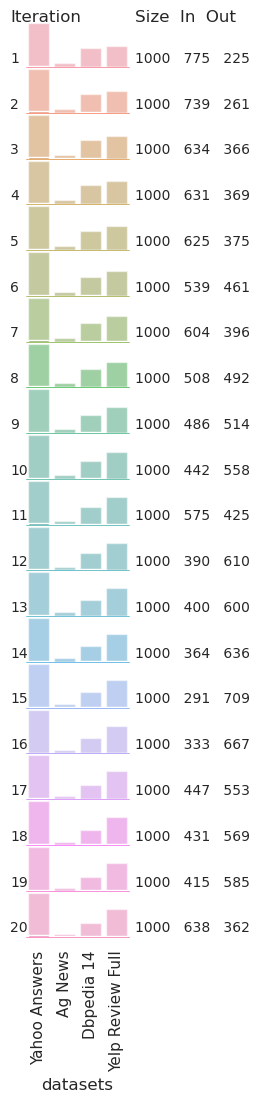

In [27]:
indices = [0]

for index in indices:
    # Load distribution from history
    history = history_list[index]

    # Make a dataframe to plot
    classes = []
    datasets = []
    count = []
    total = []
    iteration = []

    if subset == 'selected': 
        for itr, dist in enumerate(history[subset.lower()+'_distribution']):
            dist = {key:sum(value.values()) for key,value in dist.items()}
            datasets += [' '.join(class_.split('_')).title() for class_ in dist.keys()]
            count += list(dist.values())
            total += [sum(value.values()) for value in history['unlabeled_distribution'][itr].values()]
            iteration += [itr]*len(list(dist.keys()))
        df = pd.DataFrame(dict(datasets=datasets, count=count, total=total, iteration=iteration))
    else: 
        for itr, dist in enumerate(history[subset.lower()+'_distribution']):
            classes += list(dist.keys())
            count += list(dist.values())
            iteration += [itr]*len(list(dist.keys()))
        df = pd.DataFrame(dict(classes=classes, count=count, iteration=iteration))


    # Initialize the FacetGrid object
    iterations  = len(history[subset.lower() + '_distribution'])
    class_count = len(history[subset.lower() + '_distribution'][0])

    if dataset == 'dbpedia_14':
        if subset == 'selected':
            if class_count == 14: aspect = 12 if iterations > 22 else 9
            else: aspect = 7.8 if iterations > 21 else 4.5
        elif subset == 'pseudo' or subset == 'predicted':
            aspect = 6.5 if iterations > 21 else 4.5
        else:
            if class_count == 14: aspect = 11   
            else: aspect = 6.6 if iterations > 15 else 4.5
    elif dataset == 'yahoo_answers':
        if subset == 'selected':
            if class_count == 10: 
                if iterations > 21: aspect = 10
                elif iterations > 15: aspect = 6
                else: aspect = 6
            else: 
                if iterations > 21: aspect = 6.8 
                elif iterations > 15: aspect = 3.5
                else: aspect= 3.3
        elif subset == 'pseudo':
            if iterations > 21: aspect = 5.1  
            elif iterations > 15: aspect = 6
            else: aspect = 3.3
        elif subset == 'predicted':
            if iterations > 21: aspect = 5.7
            elif iterations > 15: aspect = 6
            else: aspect = 3.3
        else: 
            if iterations > 21: aspect = 5.7
            elif iterations > 15: aspect = 6
            else: aspect = 3.3
    else: raise NotImplementedError
    
    # Set size to ensure same width
    height = 0.5
    grid = sns.FacetGrid(df, row="iteration", hue="iteration", aspect=aspect, height=height,\
        sharey=False if subset=='selected' else False, sharex=True, palette=sns.color_palette("husl", iterations))

    # Draw the densities in a few steps
    if subset=='selected':
        grid.map(sns.barplot, 'datasets', 'total', errorbar=None, alpha=0.5, clip_on=False)    
        grid.map(sns.barplot, 'datasets', 'count', errorbar=None, clip_on=False)
    else: grid.map(sns.barplot, 'classes', 'count', errorbar=None, clip_on=False)
        
    # Passing color=None to refline() uses the hue mapping
    grid.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)

    # Set labels
    if subset == 'selected': grid.map(class_label, "datasets")
    else: grid.map(class_label, "classes")

    # Set the subplots to overlap
    grid.figure.subplots_adjust(hspace=-.005)

    # Set axes details
    grid.set_titles("")
    grid.set(yticks=[], ylabel="")
    grid.despine(bottom=True, left=True)

    # Set headings
    if subset=='selected': 
        plt.xticks(rotation='vertical')
        plt.suptitle(subset.title()+" Set Class Distribution", fontsize='large', x=0.82, y=1.005)
    else: 
        ticks = list(history[subset.lower()+'_distribution'][0].keys())
        labels = [class_labels[dataset][tick] for tick in ticks]
        plt.xticks(ticks,labels=labels,rotation='vertical')
        plt.suptitle(subset.title()+" Set Class Distribution", fontsize='large', x=0.5, y=1.005)

    plt.text(-0.15,1,"Iteration", transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})
    if subset =='selected': plt.text(1.05,1,'Size  In  Out', transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})
    else: plt.text(1.05,1,'Size', transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})

    # Plot
    # plt.savefig('ztest/'+str(iterations)+'_'+subset,bbox_inches="tight")
    # name = 'ls_'+str(history['config']['labeled_size'])+'_idr_'+str(history['config']['unlabeled_in_domain_ratio'])+\
    #        '_'+subset+'_class_dist_v'+version+'.svg'
    # plt.savefig(name,bbox_inches='tight');
    plt.show();
  ##
###################################

#### Save

In [8]:
# ['pseudo', 'labeled', 'unlabeled', 'train', 'predicted', 'selected']
datasets = history_dict.datasets
runs = history_dict.runs[0]
subsets = ['predicted','selected','pseudo']# 'train',# 'pseudo','predicted','selected']
for dataset in datasets:
    for run in runs:
        history_list = history_dict[dataset][run]
        for subset in subsets:
            for history in tqdm(history_list, desc=dataset.title()+', '+run.title()+', '+subset.title()):

                # Make save dir
                plots_dir = make_save_dir(history)

                # Make a dataframe to plot
                classes = []
                datasets = []
                count = []
                total = []
                iteration = []

                if subset == 'selected': 
                    for itr, dist in enumerate(history[subset.lower()+'_distribution']):
                        dist = {key:sum(value.values()) for key,value in dist.items()}
                        datasets += [' '.join(class_.split('_')).title() for class_ in dist.keys()]
                        count += list(dist.values())
                        total += [sum(value.values()) for value in history['unlabeled_distribution'][itr].values()]
                        iteration += [itr]*len(list(dist.keys()))
                    df = pd.DataFrame(dict(datasets=datasets, count=count, total=total, iteration=iteration))
                else: 
                    for itr, dist in enumerate(history[subset.lower()+'_distribution']):
                        classes += list(dist.keys())
                        count += list(dist.values())
                        iteration += [itr]*len(list(dist.keys()))
                    df = pd.DataFrame(dict(classes=classes, count=count, iteration=iteration))


                # Initialize the FacetGrid object
                iterations  = len(history[subset.lower() + '_distribution'])
                class_count = len(history[subset.lower() + '_distribution'][0])

                if dataset == 'dbpedia_14':
                    if subset == 'selected':
                        if class_count == 14: aspect = 12 if iterations > 22 else 9
                        else: aspect = 7.8 if iterations > 21 else 4.5
                    elif subset == 'pseudo' or subset == 'predicted':
                        aspect = 6.5 if iterations > 21 else 4.5
                    else:
                        if class_count == 14: aspect = 11   
                        else: aspect = 6.6 if iterations > 15 else 4.5
                elif dataset == 'yahoo_answers':
                    if subset == 'selected':
                        if class_count == 10: 
                            if iterations > 21: aspect = 10
                            elif iterations > 15: aspect = 6
                            else: aspect = 6
                        else: 
                            if iterations > 21: aspect = 6.8 
                            elif iterations > 15: aspect = 3.5
                            else: aspect= 3.3
                    elif subset == 'pseudo':
                        if iterations > 21: aspect = 5.1  
                        elif iterations > 15: aspect = 6
                        else: aspect = 3.3
                    elif subset == 'predicted':
                        if iterations > 21: aspect = 5.7
                        elif iterations > 15: aspect = 6
                        else: aspect = 3.3
                    else: 
                        if iterations > 21: aspect = 5.7
                        elif iterations > 15: aspect = 6
                        else: aspect = 3.3
                else: raise NotImplementedError
                
                # Set size to ensure same width
                height = 0.5
                grid = sns.FacetGrid(df, row="iteration", hue="iteration", aspect=aspect, height=height,\
                    sharey=False if subset=='selected' else False, sharex=True, palette=sns.color_palette("husl", iterations))

                # Draw the densities in a few steps
                if subset=='selected':
                    grid.map(sns.barplot, 'datasets', 'total', errorbar=None, alpha=0.5, clip_on=False)    
                    grid.map(sns.barplot, 'datasets', 'count', errorbar=None, clip_on=False)
                else: grid.map(sns.barplot, 'classes', 'count', errorbar=None, clip_on=False)
                    
                # Passing color=None to refline() uses the hue mapping
                grid.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)

                # Set labels
                if subset == 'selected': grid.map(class_label, "datasets")
                else: grid.map(class_label, "classes")

                # Set the subplots to overlap
                grid.figure.subplots_adjust(hspace=-.005)

                # Set axes details
                grid.set_titles("")
                grid.set(yticks=[], ylabel="")
                grid.despine(bottom=True, left=True)

                # Set headings
                if subset=='selected': 
                    plt.xticks(rotation='vertical')
                    plt.suptitle(subset.title()+" Set Class Distribution", fontsize='large', x=0.82, y=1.005)
                else: 
                    ticks = list(history[subset.lower()+'_distribution'][0].keys())
                    labels = [class_labels[dataset][tick] for tick in ticks]
                    plt.xticks(ticks,labels=labels,rotation='vertical')
                    plt.suptitle(subset.title()+" Set Class Distribution", fontsize='large', x=0.5, y=1.005)

                plt.text(-0.15,1,"Iteration", transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})
                if subset =='selected': plt.text(1.05,1,'Size  In  Out', transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})
                else: plt.text(1.05,1,'Size', transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})


                # Save
                plt.savefig(plots_dir+'/'+subset+"_set_class_dist.png",bbox_inches="tight");
                plt.clf();
                plt.close('all');
                del(df)
                del(history)
                del(grid)
                gc.collect()

Yahoo_Answers, Run5, Pseudo: 100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


### 3.3 Metric plots

#### Supporting Functions

In [ ]:
def get_stats(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    mean, sem = np.mean(a), scipy.stats.sem(a)
    ci = sem * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, ci

#### Accuracy Comparison

In [41]:
# dict(color='LightSkyBlue', line=dict(color='MediumPurple', width=2), size=10, symbol='circle'),
markers = {0.05:dict(size=6, symbol='circle'),
           0.25:dict(size=6, symbol='square'),
           0.5:dict(size=6, symbol='x'),
           0.75:dict(size=6, symbol='diamond-tall'),
           1:dict(size=6, symbol='star')}

#            Blue                  Red                   Green                 Yellow                Purple
#            Dark       Light      Dark       Light      Dark       Light      Dark       Light      Dark       Light
# colors = ['#1e74ae', '#7cbde9', '#cd181b', '#f28c8e', '#34a02c', '#a2d973', '#cb8e01', '#fdd068', '#7141a4', '#af8ac1']
colors = {'min_max' :{100:'rgba(124, 189, 233,0.2)', 500:'rgba(242, 140, 142, 0.2)', 1000:'rgba(162, 217, 115, 0.2)', 5000 :'rgba(175, 138, 193, 0.2)'},#, 2500:'#fdd068'
          'avg'     :{100:'#1e74ae', 500:'#cd181b', 1000:'#34a02c', 5000 :'#7141a4'}}#, 2500:'#cb8e01'

runs = history_dict.runs[0]
for dataset in history_dict.datasets:
    fig = go.Figure()

    # Legend Keys    
    # in_domain_ratio
    for key,value in markers.items():
        fig.add_trace(
            go.Scatter(
                mode='markers',
                x = [None],
                y = [None],
                # line = dict(width=value,color='black'),
                name = str(int(key*100))+'%',
                legendgroup='in_domain_ratio',
                legendgrouptitle_text='In Domain Ratio (IDR)',
                marker = dict(size=10,symbol=value['symbol'],color='black'),
            ))

    # labeled_size
    for key,value in colors['avg'].items():
        fig.add_trace(
            go.Scatter(
                mode='lines',
                x = [None],
                y = [None],
                line = dict(width=4,color=value,dash='solid'),
                name = str(key),
                legendgroup='labeled_size',
                legendgrouptitle_text='Labeled Size (LS)',
            ))

    #configs
    config_names = [hs['file_name'] for hs in history_dict[dataset][runs[0]]]
    sorted_config_names = alpha_sort(config_names)
    sorted_idx = [config_names.index(name) for name in sorted_config_names]
    for idx in sorted_idx:
        history = history_dict[dataset][runs[0]][idx]
        if history['config']['unlabeled_in_domain_ratio'] in markers.keys():
            config = '_'.join(history['file_name'].split('_')[0:5])

            # Get same config history from other runs
            history_list = [history]
            for run in runs[1:]:
                for hs in history_dict[dataset][run]:
                    hs_config = '_'.join(hs['file_name'].split('_')[0:5])
                    if hs_config == config:
                        history_list.append(hs)
        
            # Get Params
            labeled_size = history['config']['labeled_size']
            in_domain_ratio = history['config']['unlabeled_in_domain_ratio']

            # Get number of max iterations
            itrs = 0
            for hs in history_list:
                if len(hs['iteration']) > itrs: itrs = len(hs['iteration'])

            # Accumulate Test Accuracies
            test_accs = []
            for itr in range(itrs):
                test_accs.append([])
                for hs in history_list:
                    try: test_accs[-1].append(hs['test_acc'][itr][0])
                    except: 
                        try: test_accs[-1].append(hs['test_acc'][itr])
                        except: pass

            mean_accs = []
            max_accs = []
            min_accs = []
            std_accs = []
            ci_accs= []

            for accs in test_accs:
                mean, ci = get_stats(accs)
                mean_accs.append(mean)
                ci_accs.append(ci)
                max_accs.append(np.max(accs))
                min_accs.append(np.min(accs))
                std_accs.append(np.std(accs))

            std_up = np.array(mean_accs)+np.array(std_accs)
            std_dwn = np.array(mean_accs)-np.array(std_accs)

            ci_up = np.array(mean_accs)+np.array(ci_accs)
            ci_dwn = np.array(mean_accs)-np.array(ci_accs)

            itrs = [*range(1,len(mean_accs)+1)]
            
            fig.add_trace(
                go.Scatter(
                    mode='lines+markers',
                    x =itrs,
                    y = mean_accs,
                    line = dict(color=colors['avg'][labeled_size]),
                    name = 'LS '+str(labeled_size)+'; IDR '+str(int(in_domain_ratio*100))+'%',
                    legendgroup='ls_idr',
                    legendgrouptitle_text="Labeled Size, In Domain Ratio",
                    marker = markers[in_domain_ratio],
                )
            )
            fig.add_trace(
                go.Scatter(
                    x=itrs+itrs[::-1],
                    y=np.concatenate((ci_up,ci_dwn[::-1])),
                    fill='toself',
                    fillcolor=colors['min_max'][labeled_size],
                    line_color=colors['min_max'][labeled_size],
                    legendgroup='ls_idr_ci',
                    legendgrouptitle_text="95% Confidence Interval",
                    name = 'LS '+str(labeled_size)+'; IDR '+str(int(in_domain_ratio*100))+'%',
                )
            )
            fig.add_trace(
                go.Scatter(
                    x=itrs+itrs[::-1],
                    y=np.concatenate((std_up,std_dwn[::-1])),
                    fill='toself',
                    fillcolor=colors['min_max'][labeled_size],
                    line_color=colors['min_max'][labeled_size],
                    legendgroup='ls_idr_std',
                    legendgrouptitle_text="STD Range",
                    name = 'LS '+str(labeled_size)+'; IDR '+str(int(in_domain_ratio*100))+'%',
                )
            )
            fig.add_trace(
                go.Scatter(
                    x=itrs+itrs[::-1],
                    y=max_accs+min_accs,
                    fill='toself',
                    fillcolor=colors['min_max'][labeled_size],
                    line_color=colors['min_max'][labeled_size],
                    legendgroup='ls_idr_mnmx',
                    legendgrouptitle_text="Min-Max Range",
                    name = 'LS '+str(labeled_size)+'; IDR '+str(int(in_domain_ratio*100))+'%',
                )
            )
            
            
    fig.update_layout(
    legend=dict(
            font=dict(size=13,color="black"),
            groupclick="toggleitem",
            itemdoubleclick='toggleothers',
            grouptitlefont=dict(size=15,color='black')
        ),
        title=dict(text='Accuracy Plot',font=dict(size=25)),
        font=dict(size=15),
        template='plotly_white')
    fig.update_xaxes(title_text='iteration')
    fig.update_yaxes(title_text='accuracy')
    fig.write_html(os.path.join(base_dir,dataset,history['strategy'],"acc_comparison.html"),auto_open=False)
    # fig.write_html('test.html',auto_open=False)

#### Mean Acc for LS

In [15]:
ls_list = [100,500,1000,5000]
in_domain_ratio_list = [0.05,0.25,0.75,1.0]

plot_dir = os.path.join(base_dir,dataset,history_dict[history_dict.datasets[0]][history_dict.runs[0][0]][0]['strategy'],'Avg_Plots')
os.makedirs(plot_dir,exist_ok=True)

for dataset in history_dict.datasets:
    data_dict = {}
    for run,histories in history_dict[dataset].items():
        for his in histories:
            ls = his['config']['labeled_size']
            idr = his['config']['unlabeled_in_domain_ratio']
            if ls in data_dict: 
                if idr in data_dict[ls]: data_dict[ls][idr].append(his)
                else: data_dict[ls][idr]=[his]
            else: 
                data_dict[ls]={idr:[his]}
    
    # Set figure
    fig, ax = plt.subplots(2, 2,figsize=(12,6))
   
    axes = np.array(ax).flatten()
    sns.set_style('whitegrid')

    for (ls, ls_dict), ax in zip(data_dict.items(),axes):
        itrs = []
        test_accs = []
        idr_list = []
        for idr in in_domain_ratio_list:
            histories = ls_dict[idr]
            
            for his in histories:
                accs = []
                for acc in his['test_acc']:
                    try: accs.append(acc[0])
                    except: 
                        try: accs.append(acc)
                        except: pass
                test_accs+=accs[1:]
                itrs+=his['iteration'][1:]
                idr_list += ([idr]*len(his['iteration'][1:]))

        df = pd.DataFrame(dict(Itr=itrs, Acc=test_accs,IDR=idr_list))
        
        # Plot the lines
        sns.lineplot(df ,x='Itr',y='Acc', hue='IDR',dashes=False,markers='o',palette=sns.color_palette("husl",len(in_domain_ratio_list)),ax=ax)   
        # Adjust border
        sns.despine(top=True,right=True)

        # Set Labels, legends and ticks
        ax.set_title('Labeled Size: '+str(ls))
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.legend(facecolor="w")#,loc=4,title='IDR')
        ax.set_xticks([*range(2,21,2)],labels=[*range(2,21,2)])
        ax.set_xlim(1,24.6)
   
    # Plot
    axes[-1].set_xlabel("Iteration")
    axes[-2].set_xlabel("Iteration")
    axes[0].set_ylabel("Accuracy")
    axes[2].set_ylabel("Accuracy")
    plt.tight_layout()
    # plt.show();

    plt.savefig(os.path.join(plot_dir,'accuracy_plot_'+version+'.png'),bbox_inches="tight");
    plt.savefig(os.path.join(plot_dir,'accuracy_plot_'+version+'.svg'),bbox_inches="tight");
    plt.clf();
    plt.close('all');

#### Avg Selection Percentage

In [18]:

ls_list = [100,500,1000,5000]
in_domain_ratio_list = [0.05,0.25,0.75,1.0]

plot_dir = os.path.join(base_dir,dataset,history_dict[history_dict.datasets[0]][history_dict.runs[0][0]][0]['strategy'],'Avg_Plots')

os.makedirs(plot_dir,exist_ok=True)

for dataset in history_dict.datasets:
    data_dict = {}
    for run,histories in history_dict[dataset].items():
        for his in histories:
            ls = his['config']['labeled_size']
            idr = his['config']['unlabeled_in_domain_ratio']
            if ls in data_dict: 
                if idr in data_dict[ls]: data_dict[ls][idr].append(his)
                else: data_dict[ls][idr]=[his]
            else: 
                data_dict[ls]={idr:[his]}
    

    # Set figure
    fig, ax = plt.subplots(2, 2,figsize=(12,6))
   
    axes = np.array(ax).flatten()
    sns.set_style('whitegrid')
    
    for (ls, ls_dict), ax in zip(data_dict.items(),axes):
        itrs = []
        in_pcs = []
        idr_list = []

        for idr in in_domain_ratio_list:
            histories = ls_dict[idr]
            for his in histories:
                in_pc = (np.array(his['selected_in_domain'])/np.array(his['selected_set_size'])).tolist()
                in_pcs += in_pc
                # out_pcs += (np.array(his['selected_out_domain'])/np.array(his['selected_set_size'])).tolist()
                itrs+=[*range(1,len(in_pc)+1)]
                idr_list += ([idr]*len(in_pc))

        df = pd.DataFrame(dict(Itr=itrs, ratio=in_pcs,IDR=idr_list))
        
        # Plot the lines
        sns.lineplot(df ,x='Itr',y='ratio', hue='IDR',dashes=False,markers='o',palette=sns.color_palette("husl",len(in_domain_ratio_list)),ax=ax)        # Adjust border
        # Adjust border
        sns.despine(top=True,right=True)

        # Set Labels, legends and ticks
        ax.set_title('Labeled Size: '+str(ls))
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.legend(facecolor="w")#,loc=4,title='IDR')
        ax.set_xticks([*range(2,21,2)],labels=[*range(2,21,2)])
        ax.set_xlim(1,24.6)
    
    # Plot
    axes[-1].set_xlabel("Iteration")
    axes[-2].set_xlabel("Iteration")
    axes[0].set_ylabel("In-Domain Selection Ratio")
    axes[2].set_ylabel("In-Domain Selection Ratio")
    plt.tight_layout()
    # plt.show();

    plt.savefig(os.path.join(plot_dir,'selection_plot_'+version+'.png'),bbox_inches="tight");
    plt.savefig(os.path.join(plot_dir,'selection_plot_'+version+'.svg'),bbox_inches="tight");
    plt.clf();
    plt.close('all');

#### Accuracy for each Config

##### Plot

In [45]:
dataset = history_dict.datasets[0]
run = history_dict.runs[0][0]
history_list = history_dict[dataset][run]

iter_lens = [len(history['iteration']) for history in history_list]
sorted_ = sorted(list(set(iter_lens)))
indices = [iter_lens.index(val) for val in sorted_]
print('Dataset  :', dataset)
print('Strategy :', history_list[0]['strategy'])
print('Run      :', run)
print('Indices  :', indices)
print('Unique   :', sorted_)
print('Iter Lens:', iter_lens)

Dataset  : yahoo_answers
Strategy : pc_top_k
Run      : Run1
Indices  : [0]
Unique   : [20]
Iter Lens: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


In [46]:
index = 1
# Load Probs from history
history = history_list[index]

# Make a dataframe to plot
val_acc = [max(accs) for accs in history['val_acc']]
max_idx = [his.index(acc) for his, acc in zip(history['val_acc'],val_acc)]
train_acc = [his[idx] for his,idx in zip(history['train_acc'],max_idx)]
test_acc = [acc[0] for acc in history['test_acc']]
df = pd.DataFrame(dict(val_acc=val_acc, train_acc=train_acc, test_acc=test_acc))

# Set plot size
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
# Plot the lines
sns.lineplot(df,dashes=False,markers='o',palette=sns.color_palette("husl", 3))
# Adjust border
sns.despine(top=True,right=True)
# Set Labels, legends and ticks
plt.title('Accuracy Plot')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend(facecolor="w")
# plt.xticks([*range(0,len(history['iteration']),len(history['iteration'])//20)],labels=[*range(1,len(history['iteration'])+1,len(history['iteration'])//20)])
# Plot
plt.show()

TypeError: 'float' object is not subscriptable

##### Save

In [47]:
datasets = history_dict.datasets
runs = history_dict.runs[0]
for dataset in datasets:
    for run in runs:
        history_list = history_dict[dataset][run]
        for history in tqdm(history_list, desc=dataset.title()+', '+run.title()):
        
            # Make save dir
            plots_dir=make_save_dir(history)
            
            val_acc = [max(accs) for accs in history['val_acc']]
            max_idx = [his.index(acc) for his, acc in zip(history['val_acc'],val_acc)]
            train_acc = [his[idx] for his,idx in zip(history['train_acc'],max_idx)]
            try: test_acc = [acc[0] for acc in history['test_acc']]
            except: test_acc = [acc for acc in history['test_acc']]
            df = pd.DataFrame(dict(val_acc=val_acc, train_acc=train_acc, test_acc=test_acc))

            # Set plot size
            plt.figure(figsize=(10,5))
            sns.set_style('whitegrid')
            # Plot the lines
            sns.lineplot(df,dashes=False,markers='o',palette=sns.color_palette("husl", 3))
            # Adjust border
            sns.despine(top=True,right=True)
            # Set Labels, legends and ticks
            plt.title('Accuracy Plot')
            plt.xlabel("Iteration")
            plt.ylabel("Accuracy")
            plt.legend(facecolor="w")
            # plt.xticks([*range(0,len(history['iteration']),max(len(history['iteration'])//20,1))],\
            #     labels=[*range(1,len(history['iteration'])+1,max(len(history['iteration'])//20,1))])

            # Save
            plt.savefig(plots_dir+'/'+"acc_plot.png",bbox_inches="tight");
            plt.clf();
            plt.close('all');

Yahoo_Answers, Run5: 100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


#### Classwise metrics for each Config

##### Plot

In [ ]:
dataset = history_dict.datasets[0]
run = history_dict.runs[0][0]
history_list = history_dict[dataset][run]

iter_lens = [len(history['iteration']) for history in history_list]
sorted_ = sorted(list(set(iter_lens)))
indices = [iter_lens.index(val) for val in sorted_]
print('Dataset  :', dataset)
print('Strategy :', history_list[0]['strategy'])
print('Run      :', run)
print('Indices  :', indices)
print('Unique   :', sorted_)
print('Iter Lens:', iter_lens)

Dataset  : yahoo_answers
Strategy : pc_top_k
Run      : Run1
Indices  : [3, 6, 2, 0]
Unique   : [17, 18, 19, 20]
Iter Lens: [20, 20, 19, 17, 20, 17, 18, 17, 19, 20, 17, 18, 18, 20, 18, 19, 20, 18, 18, 17]


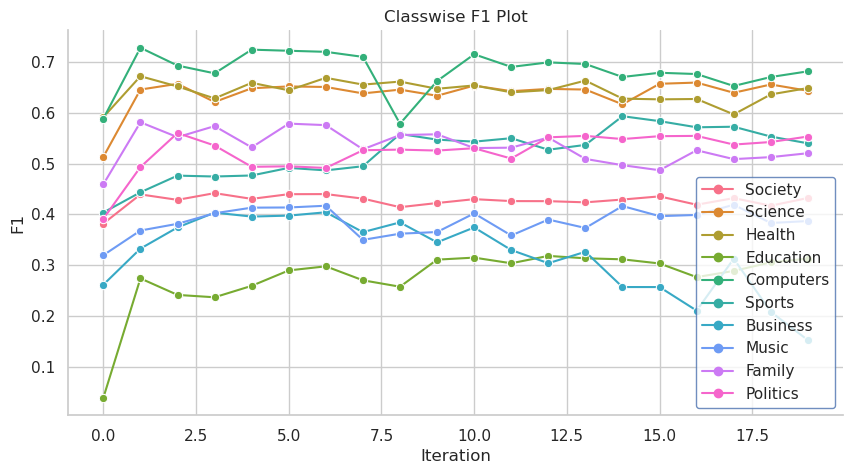

In [ ]:
index = 0
metric = 'f1' # acc, f1

# Load Probs from history
history = history_list[index]
cw_acc_dict = {class_:[] for class_ in range(len(history['test_cw_'+metric][0][0]))}
for cw_acc_list in history['test_cw_'+metric]:
    for class_, acc in enumerate(cw_acc_list[0]):
        cw_acc_dict[class_].append(acc)

df=pd.DataFrame()
for key, val in cw_acc_dict.items():
    df[class_labels[dataset][key]]=val

# Set plot size
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
# Plot the lines
sns.lineplot(df,dashes=False,lw=1.5, markers='o', palette=sns.color_palette("husl", df.shape[1]))
# Adjust border
sns.despine(top=True,right=True)
# Set Labels, legends and ticks
plt.title("Classwise "+metric.title()+' Plot')
plt.xlabel("Iteration")
plt.ylabel(metric.title())
plt.legend(facecolor="w",edgecolor='b')
# plt.xticks([*range(len(history['iteration']))],labels=[*range(1,len(history['iteration'])+1)])

# Plot
plt.show()

##### Save

In [48]:
metrics = ['acc', 'f1'] # acc, f1

datasets = history_dict.datasets
runs = history_dict.runs[0]
for dataset in datasets:
    for run in runs:
        history_list = history_dict[dataset][run]
        for history in tqdm(history_list, desc=dataset.title()+', '+run.title()):
            for metric in metrics:
                # Make save dir
                plots_dir = make_save_dir(history)
                
                # Load Probs from history
                try: cw_acc_dict = {class_:[] for class_ in range(len(history['test_cw_'+metric][0][0]))}
                except: cw_acc_dict = {class_:[] for class_ in range(len(history['test_cw_'+metric][0]))}
                for cw_acc_list in history['test_cw_'+metric]:
                    try:
                        for class_, acc in enumerate(cw_acc_list[0]):
                            cw_acc_dict[class_].append(acc)
                    except:
                        for class_, acc in enumerate(cw_acc_list):
                            cw_acc_dict[class_].append(acc)

                df=pd.DataFrame()
                for key, val in cw_acc_dict.items():
                    df[class_labels[dataset][key]]=val

                # Set plot size
                plt.figure(figsize=(10,5))
                sns.set_style("whitegrid")
                # Plot the lines
                sns.lineplot(df,dashes=False,lw=1.5, markers='o', palette=sns.color_palette("husl", df.shape[1]))
                # Adjust border
                sns.despine(top=True,right=True)
                # Set Labels, legends and ticks
                plt.title("Classwise "+metric.title()+' Plot')
                plt.xlabel("Iteration")
                plt.ylabel(metric.title())
                plt.legend(facecolor="w")
                # plt.xticks([*range(len(history['iteration']))],labels=[*range(1,len(history['iteration'])+1)])

                # Save
                plt.savefig(plots_dir+'/'+"cw_"+metric+"_plot.png",bbox_inches="tight");
                plt.clf();
                plt.close('all');

Yahoo_Answers, Run5: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


### 3.4 Selection plots

#### Plot

In [49]:
dataset = history_dict.datasets[0]
run = history_dict.runs[0][3]
history_list = history_dict[dataset][run]

iter_lens = [len(history['iteration']) for history in history_list]
sorted_ = sorted(list(set(iter_lens)))
indices = [iter_lens.index(val) for val in sorted_]
print('Dataset  :', dataset)
print('Strategy :', history_list[0]['strategy'])
print('Run      :', run)
print('Indices  :', indices)
print('Unique   :', sorted_)
print('Iter Lens:', iter_lens)

Dataset  : yahoo_answers
Strategy : pc_top_k
Run      : Run4
Indices  : [0]
Unique   : [20]
Iter Lens: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


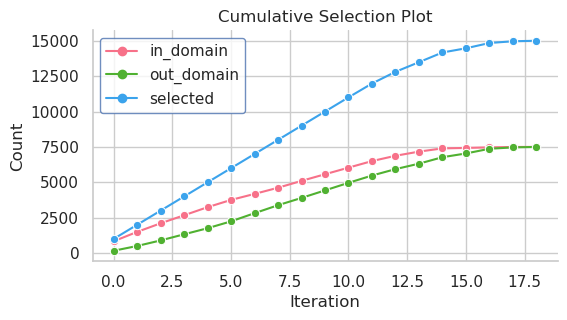

In [109]:
index = 0

# Load Probs from history
history = history_list[index]

# Make a dataframe to plot
in_domain = deepcopy(history['selected_in_domain'])
out_domain = deepcopy([a-b for a,b in zip(history['selected_set_size'],history['selected_in_domain'])])
selected = deepcopy(history['selected_set_size'])

for i in range(1,len(in_domain)):
    in_domain[i] = in_domain[i-1]+in_domain[i]
    out_domain[i] = out_domain[i-1]+out_domain[i]
    selected [i]= selected[i-1]+selected[i]

df = pd.DataFrame(dict(in_domain=in_domain, out_domain=out_domain, selected=selected))

# Set plot size
plt.figure(figsize=(6,3))
sns.set_style("whitegrid")
# Plot the lines
sns.lineplot(df,dashes=False,markers='o',palette=sns.color_palette("husl", 3))
# Adjust border
sns.despine(top=True,right=True)
# Set Labels, legends and ticks
plt.title('Cumulative Selection Plot')
plt.xlabel("Iteration")
plt.ylabel("Count")
plt.legend(facecolor="w",edgecolor='b')
# plt.xticks([*range(len(history['iteration']))],labels=[*range(1,len(history['iteration'])+1)])

# Plot
plt.show()

#### Save

In [50]:
datasets = history_dict.datasets
runs = history_dict.runs[0]
for dataset in datasets:
    for run in runs:
        history_list = history_dict[dataset][run]
        for history in tqdm(history_list, desc=dataset.title()+', '+run.title()):
        
            # Make save dir
            plots_dir=make_save_dir(history)

            # Make a dataframe to plot
            in_domain = deepcopy(history['selected_in_domain'])
            out_domain = deepcopy([a-b for a,b in zip(history['selected_set_size'],history['selected_in_domain'])])
            selected = deepcopy(history['selected_set_size'])

            for i in range(1,len(in_domain)):
                in_domain[i] = in_domain[i-1]+in_domain[i]
                out_domain[i] = out_domain[i-1]+out_domain[i]
                selected [i]= selected[i-1]+selected[i]

            df = pd.DataFrame(dict(in_domain=in_domain, out_domain=out_domain, selected=selected))

            # Set plot size
            plt.figure(figsize=(10,5))
            sns.set_style("whitegrid")
            # Plot the lines
            sns.lineplot(df,dashes=False,markers='o',palette=sns.color_palette("husl", 3))
            # Adjust border
            sns.despine(top=True,right=True)
            # Set Labels, legends and ticks
            plt.title('Cumulative Selection Plot')
            plt.xlabel("Iteration")
            plt.ylabel("Count")
            plt.legend(facecolor="w")
            # plt.xticks([*range(len(history['iteration']))],labels=[*range(1,len(history['iteration'])+1)])

            # Save
            plt.savefig(plots_dir+'/'+"selection_plot.png",bbox_inches="tight");
            plt.clf();
            plt.close('all');

Yahoo_Answers, Run5: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


### 3.5 Distribution Counts

In [ ]:
distribution = 'train'
index = 5
for history in history_list[index:index+1]:
    pre_title = 'Threshold: '+str(history['threshold']) if history['strategy']=='threshold' else\
                'Top K: '+str(history['top_k']) , "Labeled Size:"+str(history['labeled_set_size'][0])+\
                    ", Unlabeled Classes: "+str(len(history['unlabeled_classes']))
    print(distribution.title()+' Distribution,',pre_title)
    
    itr = history['iteration']
    unlabeled_dist = [val.values() for val in history[distribution.lower()+'_distribution']]
   
    df = pd.DataFrame(columns=['Iteration']+[str(clss) for clss in history[distribution.lower()+'_distribution'][0].keys()])
    for i, counts in zip(itr,unlabeled_dist):
        df.loc[len(df)] = [i]+ list(counts)

    display(df)

## Debug

In [ ]:
fig = px.colors.qualitative.swatches()
fig.update_layout(template='plotly_white')
fig.write_html(base_dir+"/colors.html")

In [ ]:
print(px.colors.named_colorscales())

['aggrnyl', 'agsunset', 'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'darkmint', 'electric', 'emrld', 'gnbu', 'greens', 'greys', 'hot', 'inferno', 'jet', 'magenta', 'magma', 'mint', 'orrd', 'oranges', 'oryel', 'peach', 'pinkyl', 'plasma', 'plotly3', 'pubu', 'pubugn', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdpu', 'redor', 'reds', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'turbo', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd', 'algae', 'amp', 'deep', 'dense', 'gray', 'haline', 'ice', 'matter', 'solar', 'speed', 'tempo', 'thermal', 'turbid', 'armyrose', 'brbg', 'earth', 'fall', 'geyser', 'prgn', 'piyg', 'picnic', 'portland', 'puor', 'rdgy', 'rdylbu', 'rdylgn', 'spectral', 'tealrose', 'temps', 'tropic', 'balance', 'curl', 'delta', 'oxy', 'edge', 'hsv', 'icefire', 'phase', 'twilight', 'mrybm', 'mygbm']


In [ ]:
for name in history_files:
    history = torch.load(name)
    labeled = history['labeled_set_size'][1:]+[history['unlabeled_set_size'][0]]
    unlabeled = history['unlabeled_set_size'][1:]+[0]
    history['labeled_set_size']=labeled
    history['unlabeled_set_size']=unlabeled
    torch.save(history,name)

In [ ]:
for root, dirs, files in os.walk("./history"):
   for name in files:
      print(os.path.join(root, name))
   for name in dirs:
      print(os.path.join(root, name))

Rename

In [ ]:
history_dict = dict()

for dataset in os.listdir(history_dir):
    dataset_path = os.path.join(history_dir,dataset)
    if os.path.isdir(dataset_path):
        for run in os.listdir(dataset_path):
            run_path = os.path.join(dataset_path,run)
            if os.path.isdir(run_path):
                
                if dataset in history_dict: history_dict[dataset][run] = []
                else: history_dict[dataset] = {run:[]}
                
                for path, dirs, files in os.walk(run_path):
                    for file_ in files:
                        if file_[-10:] == 'history.pt':
                            splits=file_.split('_')
                            name = '_'.join(splits[1:-1]+['e'+splits[0]]+[splits[-1]])
                            try:
                                os.rename(os.path.join(run_path,file_), os.path.join(run_path,name))
                            except:
                                pass
                            
                            # history_dict[dataset][run].append(file_)
print()

In [ ]:
files = ['20_100_equal_100_15000_25_history.pt', '17_100_equal_5000_15000_75_history.pt']

for file_ in files:
    splits=file_.split('_')
    print('_'.join(splits[1:-1]+['e'+splits[0]]+[splits[-1]]))


100_equal_100_15000_25_e20_history.pt
100_equal_5000_15000_75_e17_history.pt


In [ ]:
splits='20_100_equal_100_15000_25_history.pt'.split('_')
print('_'.join(splits[1:-1]+['e'+splits[0]]+[splits[-1]]))

100_equal_100_15000_25_e20_history.pt


In [ ]:
for path, dirs, files in os.walk(history_dir):
    print(files)

['setup.py',
 'history',
 '.old',
 'docs',
 'LICENSE',
 '.vscode',
 'visualize_v3.0.ipynb',
 'utils',
 'temp',
 'prev_versions',
 'self_train_v3.0.py',
 'self_train_v3.0 copy.py',
 'README.md',
 '.gitignore',
 'changelog.md',
 'data',
 '__pycache__',
 '.git',
 'scripts',
 '.cache']

In [ ]:
print(os.listdir(history_dir))

['yahoo_answers']
